## Libraries

In [3]:
!pip install -U tensorflow-addons
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras.regularizers import l2
from tensorflow.python.framework.ops import re


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## TripletLoss

TripletLoss is a loss function that trains a neural network to closely embed features of the same class while maximizing the distance between embeddings of different classes.  To do this an anchor  is chosen along with one negative and one positive sample.
![fig3](assets/triplet2.png)

**The loss function is described as a Euclidean distance function:**
![function](assets/triplet1.png)

![function](assets/triplet.png)

Where A is our anchor input,  P is the positive sample input,  N is the negative sample input, and alpha is some margin you use to specify when a triplet has become too "easy" and you no longer want to adjust the weights from it.

## Data Processing

In [4]:
image_size = 224
batch_size = 256

resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(image_size, image_size)
])

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.2),
        tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.3), width_factor=(-0.2,-0.3)),
        tf.keras.layers.RandomBrightness((-0.2,0.2), value_range=[0,1])
])

In [5]:
def _img(img, label):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 2.0)
    img = tf.image.random_saturation(img, 0.75, 1.25)
    img = tf.image.random_hue(img, 0.1)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return (img,label)

def _normalize_img(img,label):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img,(image_size,image_size))
    return (img,label)

train_dataset, test_dataset = tfds.load(name="oxford_flowers102", split=['train', 'validation[:40%]'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.map(_normalize_img).repeat(10).map(_img)
train_dataset = train_dataset.shuffle(512).batch(batch_size)

test_dataset = test_dataset.map(_normalize_img)
test_dataset = test_dataset.batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteN5LUHY/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteN5LUHY/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteN5LUHY/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Build the Model

In [77]:
import tensorflow_hub as hub
model_url = "https://tfhub.dev/google/bit/m-r101x1/1"
module = hub.KerasLayer(model_url)

In [96]:
from tensorflow.python.framework.ops import re
model = tf.keras.Sequential([
    module,
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(32, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(8, activation="relu"),
    # tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    tf.keras.layers.Dense(128, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

In [ ]:
model.build(input_shape=(batch_size,image_size,image_size,3))
model.summary()

## Train and Evaluate

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.004),
    loss=tfa.losses.TripletSemiHardLoss())


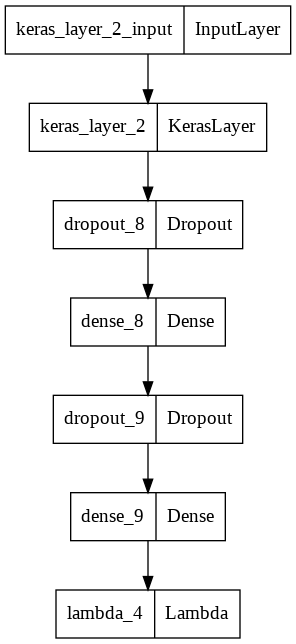

In [93]:
tf.keras.utils.plot_model(model)

In [ ]:
# Train the network
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs=200)

Epoch 1/200
40/40 [==============================] - 180s 4s/step - loss: 0.9343 - val_loss: 0.5364
Epoch 2/200
40/40 [==============================] - 135s 3s/step - loss: 0.8169 - val_loss: 0.4182
Epoch 3/200
40/40 [==============================] - 135s 3s/step - loss: 0.7483 - val_loss: 0.3374
Epoch 4/200
40/40 [==============================] - 135s 3s/step - loss: 0.7044 - val_loss: 0.2922
Epoch 5/200
40/40 [==============================] - 135s 3s/step - loss: 0.6715 - val_loss: 0.2543
Epoch 6/200
40/40 [==============================] - 136s 3s/step - loss: 0.6415 - val_loss: 0.2295
Epoch 7/200
40/40 [==============================] - 136s 3s/step - loss: 0.6186 - val_loss: 0.2012
Epoch 8/200
40/40 [==============================] - 135s 3s/step - loss: 0.6102 - val_loss: 0.1898
Epoch 9/200
40/40 [==============================] - 135s 3s/step - loss: 0.5923 - val_loss: 0.1624
Epoch 10/200
40/40 [==============================] - 135s 3s/step - loss: 0.5827 - val_loss: 0.1644

KeyboardInterrupt: ignored

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
model.load_weights('assets/TripletLoss_bestModel.hdf5')

In [ ]:
model.save_weights('best.hdf5')

In [19]:
# Evaluate the network
test = tfds.load(name="oxford_flowers102", split='test', as_supervised=True)

# Build your input pipelines

test = test.map(_normalize_img)
test = test.batch(batch_size)

results = model.predict(test)
model.evaluate(test)

25/25 [==============================] - 65s 2s/step - loss: nan


nan

## Creating Embeddings and Evaluting Performance

In [15]:
import numpy as np
import io
import requests
import json

In [ ]:
# Save test embeddings for visualization in projector
np.savetxt("v_1.tsv", results, delimiter='\t')

out_m = io.open('m_1.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
  from google.colab import files
  files.download('v_1.tsv')
  files.download('m_1.tsv')
except:
  pass

## Classifier

In [16]:
def img_to_encoding(img, model):
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding

In [17]:
# apping the number label to actual names of the flowers
file_location='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/label_map.json?raw=1'
r = requests.get(file_location, stream=True)
class_names=json.loads(r.content.decode('utf-8'))
class_names = {int(k):v for k,v in class_names.items()}

In [81]:
d ={}
database = {}

for i,j in train_dataset:
  for image, label in zip(i,j):
    if(class_names[label.numpy()+1] in database):
      database[class_names[label.numpy()+1]] += img_to_encoding(image,model)
      d[class_names[label.numpy()+1]] += 1
    else:
      database[class_names[label.numpy()+1]] = img_to_encoding(image,model)
      d[class_names[label.numpy()+1]] = 1

In [82]:
for i in database:
  database[i] = database[i]/d[i]

In [83]:
import pickle

pickle.dump(database, open("database_r101.p", "wb"))  # save it into a file named save.p

# # -------------------------------------------------------------
# # Load the dictionary back from the pickle file.
# import pickle

# favorite_color = pickle.load(open("save.p", "rb"))

In [69]:
def which_flower(img, database, model):
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(img,model)
    
    ## Step 2: Find the closest encoding ##
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    #Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    # YOUR CODE ENDS HERE
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [84]:
errors = 0
count = 0
y_pred=[]
for i,j in test:
  for image, label in zip(i,j):
    _, cat = which_flower(image,database,model)
    y_pred.append(cat)
    #print(cat,class_names[label.numpy()+1])
    count = count+1
    if(cat!=class_names[label.numpy()+1]):
      errors = errors +1

Streaming output truncated to the last 5000 lines.
it's sword lily, the distance is 0.12343005
it's marigold, the distance is 0.024333006
it's great masterwort, the distance is 0.118034355
it's tree poppy, the distance is 0.070150085
it's mallow, the distance is 0.12635021
it's wallflower, the distance is 0.09616942
it's thorn apple, the distance is 0.038594652
it's bougainvillea, the distance is 0.12913747
it's bird of paradise, the distance is 0.029231947
it's foxglove, the distance is 0.019924289
it's canterbury bells, the distance is 0.035364933
it's orange dahlia, the distance is 0.05178421
it's wallflower, the distance is 0.05082829
Not in the database.
it's mexican petunia, the distance is 0.041529525
it's morning glory, the distance is 0.03206436
it's windflower, the distance is 0.15712042
it's bee balm, the distance is 0.047806934
it's sword lily, the distance is 0.10418936
it's californian poppy, the distance is 0.08764962
it's watercress, the distance is 0.017227385
it's cyc

In [85]:
print("Accuracy: ", 1- errors/count)

Accuracy:  0.9882907789884534


### Classification Report for the Test Data

In [86]:
inv_map = {v: k for k, v in class_names.items()}
y_preds= [inv_map[i] for i in y_pred]

In [87]:
y_test=[]
for i,j in test:
  for image, label in zip(i,j):
    y_test.append(label.numpy())


In [88]:
y_preds =[i-1 for i in y_preds]

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.93      0.96        40
           2       0.95      1.00      0.98        20
           3       0.94      0.92      0.93        36
           4       1.00      0.98      0.99        45
           5       1.00      1.00      1.00        25
           6       0.91      1.00      0.95        20
           7       1.00      1.00      1.00        65
           8       0.96      1.00      0.98        26
           9       1.00      1.00      1.00        25
          10       0.99      1.00      0.99        67
          11       1.00      1.00      1.00        67
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        28
          14       1.00      1.00      1.00        29
          15       1.00      0.95      0.98        21
          16       1.00      1.00      1.00        65
          17       0.95    

## Embedding Projector

You can see the results of our embedded test data when visualized with UMAP:
![embedding](assets/embedding.png)